# Train FCN for semantic segmentation

You must only define model structure and choose loss function

After model will work, optionally add some augmentation to improve results

## Load the data

Dataset is a part of [midv500](https://arxiv.org/abs/1807.05786) dataset.
For a simplicity all quadrangles converted to png masks.



In [1]:
!pip install pytorch_memlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! wget -nc http://fmb.images.gan4x4.ru/hse/midv500p.zip
! unzip -qu midv500p.zip

--2023-02-01 22:17:59--  http://fmb.images.gan4x4.ru/hse/midv500p.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip.5’

midv500p.zip.5      100%[===================>]   8.76M  1.87MB/s    in 5.9s    

2023-02-01 22:18:06 (1.49 MB/s) - ‘midv500p.zip.5’ saved [9183651/9183651]



Dataloader.
You can use it without modification

In [3]:
import random, os
import numpy as np
import torch

# фиксируем сид
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True
  
seed_everything(122)

In [4]:
from torch.utils.data import Dataset
import glob
from PIL import Image

class MaskDataset(Dataset):
  def __init__(self, path, transform = None):
    self.files = glob.glob(path+"/image/*")
    self.masks = glob.glob(path+"/mask/*")
    self.files.sort()
    self.masks.sort()
    self.transform = transform

  def __getitem__(self, i):
    im = Image.open(self.files[i])
    mask = Image.open(self.masks[i]).convert('1') # Load mask in B/W format
    if self.transform:
      im = self.transform(im)
      mask = self.transform(mask)
    return im, mask

  def __len__(self):
    return len(self.files)

Dataloaders initialization

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

resize_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = MaskDataset('midv500p/train', transform=resize_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = MaskDataset('midv500p/val', transform=resize_transforms)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Lets show some data

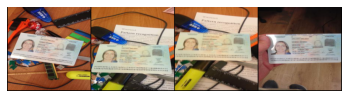

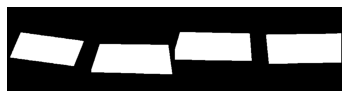

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (40,8)
%matplotlib inline

def show(batch):
  # create grid of images
  # https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
  img_grid = torch.clamp(make_grid(batch), 0, 1)
  plt.figure()
  plt.axis("off")
  plt.imshow(np.transpose(img_grid.numpy(), (1,2,0)))

images, masks = next(iter(val_loader))

show(images)
show(masks)

Tensorboard init helper

In [7]:
import os
import shutil

def reinit_tensorboard(clear_log=True):
  # Directory for log files
  logs_base_dir = "runs"
  if clear_log:
    # Clear logs
    shutil.rmtree(logs_base_dir, ignore_errors=True)
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

У нас датасет соовсем без классов, поэтому смотреть на их баланс неполучиться)

# Code for train

You must select Loss function

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(comment="image_show")


def show_results(model, epoch):
  '''
    Write obtained masks to tensorboard log
  '''
  for im, gt in val_loader:
    outputs = model(im.to(device))
    im = torch.clamp(im, 0, 1)
    writer.add_image("Images", torchvision.utils.make_grid(im), epoch)
    writer.add_image("Masks", torchvision.utils.make_grid(outputs), epoch)
    writer.flush()
    writer.close()
    return


def train(model, epochs):
  model.train()
  model.to(device)

  criterion = BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  prev_loss = 0
  for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for img_batch, masks_batch in tqdm(train_loader, desc=f"Epoch {epoch:03} Train loss {prev_loss:3.2f}"):
      masks = masks_batch.to(device)
      imgs = img_batch.to(device)

      optimizer.zero_grad()
      output = model(imgs)
      loss = criterion(output, masks)
      train_loss += loss.cpu().item() * imgs.shape[0]
      loss.backward()
      optimizer.step()

      train_acc += (output == masks).sum() / (masks.shape[0] * masks.shape[2] * masks.shape[3])

    writer.add_scalar("Train/Loss", train_loss, epoch)
    writer.add_scalar("Train/Accuracy", train_acc, epoch)
    show_results(model, epoch)
    prev_loss = train_loss


writer.close()

## Define your model sttructure here

Use [UNet](https://arxiv.org/pdf/1505.04597.pdf) - like structure.
But  decrease number of layers for simplicity.
Original images has 224x224 resolution.

In [9]:
from torch.nn import *
from torchvision.transforms import CenterCrop
import torch.nn.functional as F

# один блок конволюций
# сам он не занимается up/downsample-ингом и только меняет число каналов
class Block(Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        mid_ch = out_ch
        self.seq = Sequential(
            Conv2d(in_ch, mid_ch, 3, padding=1),
            BatchNorm2d(mid_ch),
            ReLU(inplace=True),
            Conv2d(mid_ch, out_ch, 3, padding=1),
            BatchNorm2d(out_ch),
            ReLU(inplace=True),
        )

    def forward(self, x):
        return self.seq(x)

class Encoder(Module):
    def __init__(self, chs=(3,64,128,256)):
        super().__init__()
        self.blocks = ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pools = ModuleList([MaxPool2d(2) for i in range(len(chs)-1)]) # downsample

    def forward(self, x):
        # нам тут нужно ручками прогонять каждый блок в списке, чтобы сохранить промежуточные фичи
        ftrs = []
        for pool, block in zip(self.pools, self.blocks):
            x = block(x)
            ftrs.append(x)
            x = pool(x)
        return ftrs

class Decoder(Module):
    def __init__(self, chs=(256,128,64)):
        super().__init__()
        self.chs = chs
        self.upconvs = ModuleList([ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x1 = self.upconvs[i](x)
            x2 = encoder_features[i]
            diffY = x2.shape[2] - x1.shape[2]
            diffX = x2.shape[3] - x1.shape[3]
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
            x = torch.cat([x2, x1], dim=1)
            x = self.dec_blocks[i](x)
        return x

class MiniUnet(Module):
    def __init__(self, num_classes, chs=(3,32,64,128)):
        super(MiniUnet, self).__init__()
        # Define basic blocks here
        # 3 downsample and 3 upsample block will be enough
        # даже только с тремя блоками, нейрнока туго помещяется в память (12GB)
        self.num_classes = num_classes
        self.encoder = Encoder(chs)
        self.decoder = Decoder(chs[:0:-1])
        self.head = Conv2d(chs[1], num_classes, 1)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        # Perform upsample here
        # Concatenate features from downsample path with appropriate feature maps
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        out = F.interpolate(out, (224,224))
        return self.sigmoid(out) # Segmentation mask


## Страдаем с памятью...

In [10]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| GPU reserved memory   |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------

In [11]:
from pytorch_memlab import LineProfiler
with LineProfiler(Block.forward, Encoder.forward, Decoder.forward, MiniUnet.forward, train) as prof:
    train(MiniUnet(1), epochs=1)
prof.display()


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.8/dist-packages/pytorch_memlab/line_profiler/line_profiler.py", line 81, in register_callback
    sys.settrace(self._trace_callback)

Epoch 000 Train loss 0.00: 100%|██████████| 9/9 [00:17<00:00,  1.92s/it]

PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.8/dist-packages/pytorch_memlab/line_profiler/line_profiler.py", line 100, in disa

active_bytes,reserved_bytes,line,code
all,all,,
peak,peak,,
5.49G,13.09G,20,"def forward(self, x):"
8.86G,13.09G,21,return self.seq(x)
active_bytes,reserved_bytes,line,code
all,all,,
peak,peak,,
80.69M,13.09G,29,"def forward(self, x):"
,,30,"# нам тут нужно ручками прогонять каждый блок в списке, чтобы сохранить промежуточные фичи"
80.69M,13.09G,31,ftrs = []


## Train the model

In [ ]:
reinit_tensorboard(False)

In [15]:
model = MiniUnet(1)
train(model, epochs=100)

Epoch 099 Train loss 2.21: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


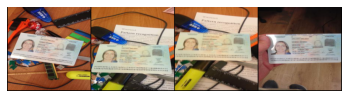

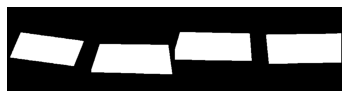

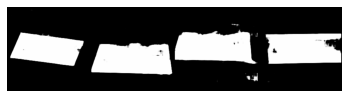

In [16]:
images, masks = next(iter(val_loader))

show(images)
show(masks)
model.eval()
output = model(images.to(device))
show(output.cpu())

## Вывод

После 200 эпох тренировки наша моделька примерно определяет форму карточки, но кажется не до конца понимает что она должна быть прямоугольная. 

Loss опустился довольно низко (был 200 стал 2), но Accuracy почти всегда 0. Наверно я его непраивльно считаю...

UNet, как оказалось, очень сильно жрёт память, потому что ей нужно хранить промежуточные значения, чтобы потом их передать декодеру.
Скорее весго, с более лучшей видеокартой, у меня бы получился более чёткий результат.

Может быть во всём виноват наш маленький датасет, хотя UNet-ы должны хорошо с ними справляться

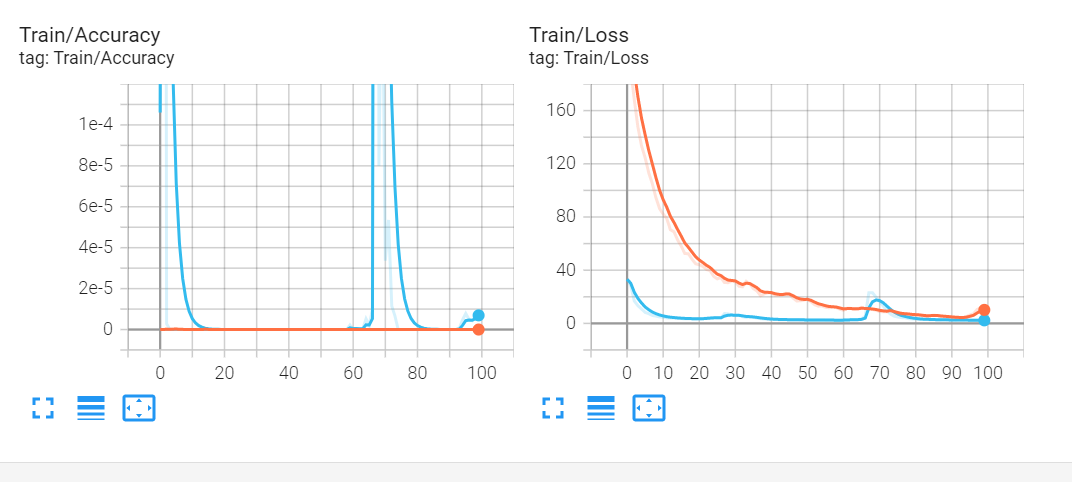